In [1]:
!git commit -a -m "update"
!git fetch upstream; git merge upstream/master master
!git commit -a -m "update"

On branch master
Your branch is up-to-date with 'origin/master'.

nothing to commit, working tree clean
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (303/303), done.
remote: Total 865 (delta 303), reused 303 (delta 303), pack-reused 562
Receiving objects: 100% (865/865), 4.33 MiB | 7.44 MiB/s, done.
Resolving deltas: 100% (563/563), completed with 31 local objects.
From github.com:CSSEGISandData/COVID-19
   6af1fed7..b397198e  master     -> upstream/master
   5f4c4552..6952bfba  web-data   -> upstream/web-data
[master bf4fcec6] update


In [27]:
import cufflinks as cf
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

cf.go_offline()

In [28]:
def get_data_V2(category='confirmed'):
    df = (
        pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{category}_global.csv')
        .rename(columns={'Province/State': 'state', 'Country/Region': 'country', 'Lat': 'latitude', 'Long': 'long'})
        .set_index(['state', 'country'])
        .drop(columns=['latitude', 'long'])
    )
    df.columns = [pd.Timestamp(col) for col in df.columns]
    df = df.reset_index().drop(columns=['state']).groupby('country').sum().transpose()
    df.index.name = 'date'
    df.columns = list(df.columns)

    return df


def get_globe(df, name, threshold=None):
    globe = df.drop(columns=['China']).sum(axis=1)
    if threshold:
        globe[globe<threshold]=np.nan
    globe = globe.apply(np.log)
    globe.name=name
    globe = globe.dropna().reset_index()
    return globe

category = 'deaths'
threshold_for_model = {'recovered': 300, 'confirmed': 1000, 'deaths': 10}

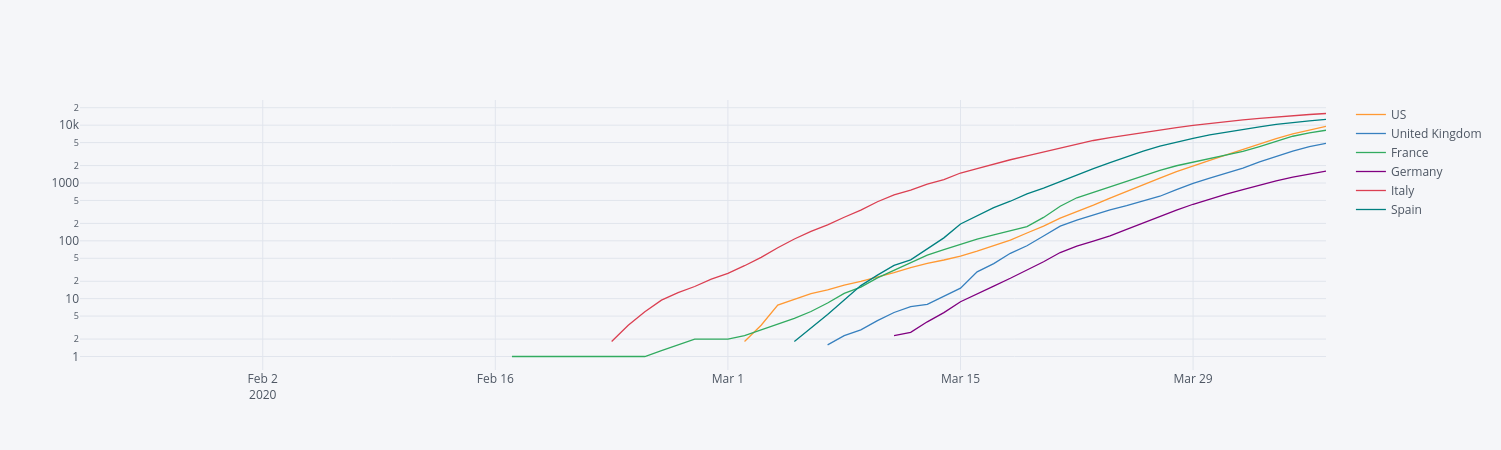

In [29]:
df[['US', 'United Kingdom', 'France', 'Germany', 'Italy', 'Spain']].apply(np.log).rolling(3).mean().apply(np.exp).iplot(logy=True)

In [30]:
n_sigma = 3
beginning_of_data = pd.Timestamp('2020-02-10')
x0 = (pd.Timestamp('today').value + beginning_of_data.value)/2

category = 'deaths'
df = get_data_V2(category)
globe = get_globe(df, category, threshold=threshold_for_model[category])
x = globe['date'].astype(int)
y = globe[category]
x_fit = pd.Series(pd.date_range('2020-02-10', '2020-05-20')).astype(int)

x = (x-x0)/x0
x_fit = (x_fit-x0)/x0

coeff, cov = np.polyfit(x, y, 2, cov=True)
coeff_min = coeff - n_sigma*np.sqrt(cov.diagonal()) * np.array([1, 0, 0])
coeff_max = coeff + n_sigma*np.sqrt(cov.diagonal()) * np.array([1, 0, 0])

fit = pd.DataFrame(pd.date_range('2020-02-10', '2020-05-20'), columns=['date']).set_index('date')
fit['min'] = np.poly1d(coeff_min)(x_fit)
fit['estimate'] = np.poly1d(coeff)(x_fit)
fit['max'] = np.poly1d(coeff_max)(x_fit)

globe = get_globe(df, category)
out = pd.concat((globe.set_index('date'), fit), axis=1)
out[out<0] = np.nan
out = out.apply(np.exp)[['min', 'max', 'estimate', category]]

In [31]:
data_date = []
data = []

for i in range(10000):
    tmp_coeff = np.random.multivariate_normal(coeff, cov)
    maxima = -tmp_coeff[1]/(2*tmp_coeff[0])
    maxima_date = pd.Timestamp(maxima*x0+x0)
    
    est_deaths = np.exp(tmp_coeff[2] - (tmp_coeff[1]*tmp_coeff[1]) / (4 * tmp_coeff[0]))
    data_date.append(maxima_date)
    data.append(est_deaths)

output = pd.Series(data_date)
total = pd.DataFrame(data)

In [32]:
tmp_coeff = coeff
maxima = -tmp_coeff[1]/(2*tmp_coeff[0])
expected_end_date = pd.Timestamp(maxima*x0+x0).date().isoformat()
expected_total_deaths = int((np.exp(tmp_coeff[2] - (tmp_coeff[1]*tmp_coeff[1]) / (4 * tmp_coeff[0]))).round(-3))

In [33]:
out = out.cummax()

### Plotting

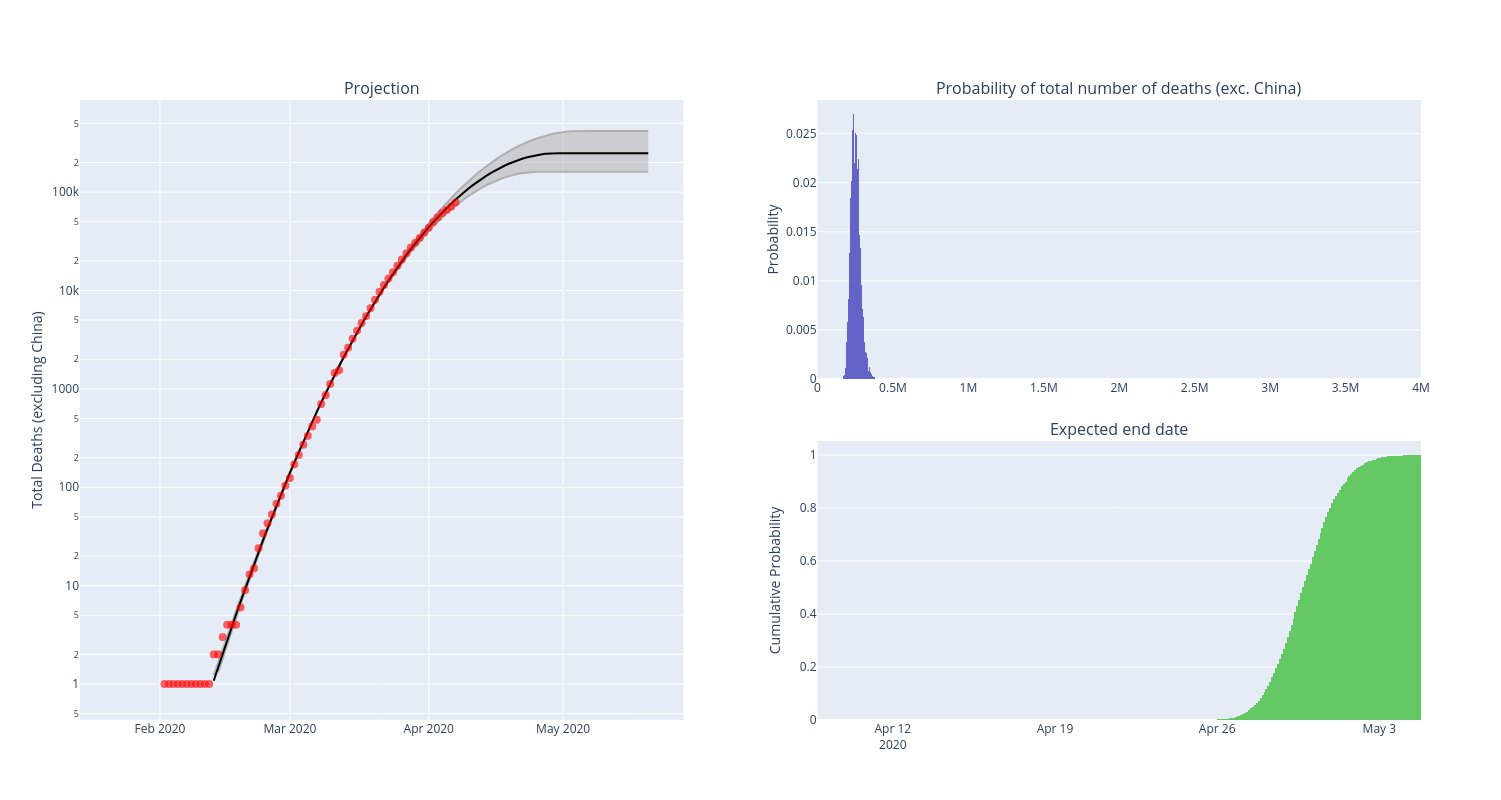

Expected end date: 2020-04-29
Expected total number of deaths excluding China: 249000


In [34]:
interior_colour = 'rgb(175, 175, 175)'

fig = plotly.subplots.make_subplots(
    rows=2, cols=2,
    vertical_spacing=0.1,
    specs=[[{'rowspan': 2}, {}],
           [None, {}]],
    subplot_titles=(
        "Projection", 
        'Probability of total number of deaths (exc. China)', 
        'Expected end date'
    )
)

fig.add_trace(go.Scatter(
    x=out.index, 
    y=out['min'],
    fill=None,
    mode='lines',
    line_color=interior_colour,
    name=''),
    row=1, col=1
    )
fig.add_trace(go.Scatter(
    x=out.index,
    y=out['max'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', 
    line_color=interior_colour),
    row=1, col=1
    )
fig.add_trace(go.Scatter(
    x=out.index, 
    y=out['estimate'],
    fill=None,
    mode='lines',
    line_color='black',
    name='Predicted Total'),
    row=1, col=1
    )
fig.add_trace(go.Scatter(
    x=out.index, 
    y=out['deaths'],
    fill=None,
    mode='markers',
    marker={'symbol': 'circle', 'size': 8, 'opacity': 0.6},
    line_color='red',
    name='Total Deaths (exc. China)'),
    row=1, col=1
    )
fig.update_yaxes(type="log", row=1, col=1)

fig.append_trace(go.Histogram(x=total[0], histnorm='probability', marker_color='rgb(100, 100, 200)'), row=1, col=2)
fig.append_trace(go.Histogram(x=output, histnorm='probability', marker_color='rgb(100, 200, 100)', cumulative_enabled=True), row=2, col=2)

fig.update_xaxes(range=[pd.Timestamp('today'), output.max()], row=2, col=2)
fig.update_xaxes(range=[0, 4e6], row=1, col=2)
fig.update_yaxes(title_text='Probability', row=1, col=2)
fig.update_yaxes(title_text='Cumulative Probability', row=2, col=2)
fig.update_yaxes(title_text='Total Deaths (excluding China)', row=1, col=1)
fig.update_layout(showlegend=False, height=800, width=1400)

fig.show()
print(
    f'Expected end date: {expected_end_date}\n'
    f'Expected total number of deaths excluding China: {expected_total_deaths}'
)

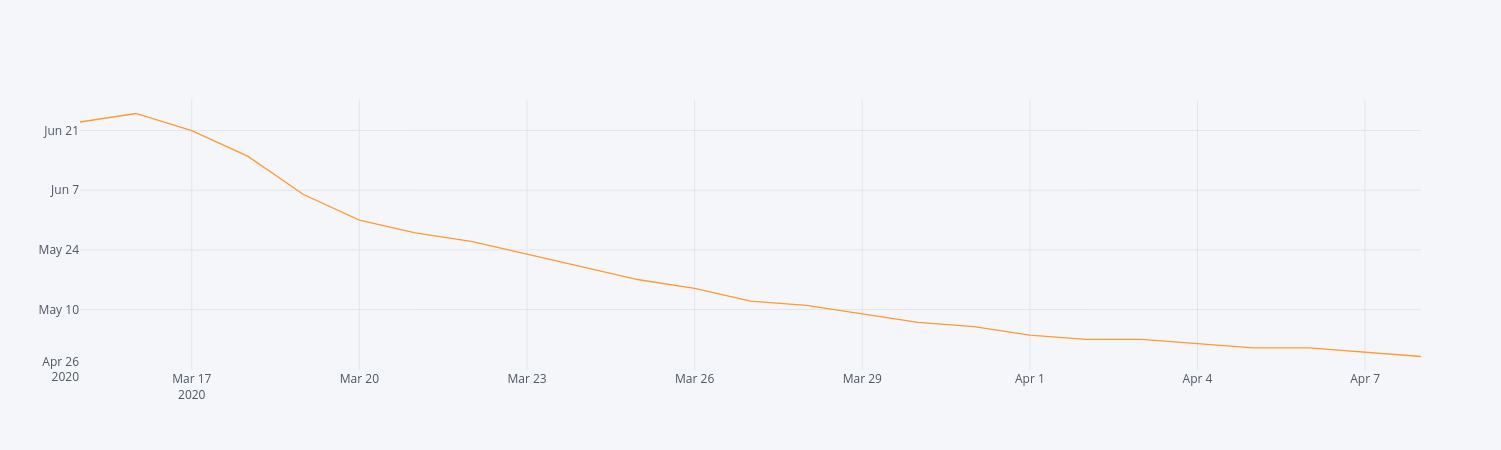

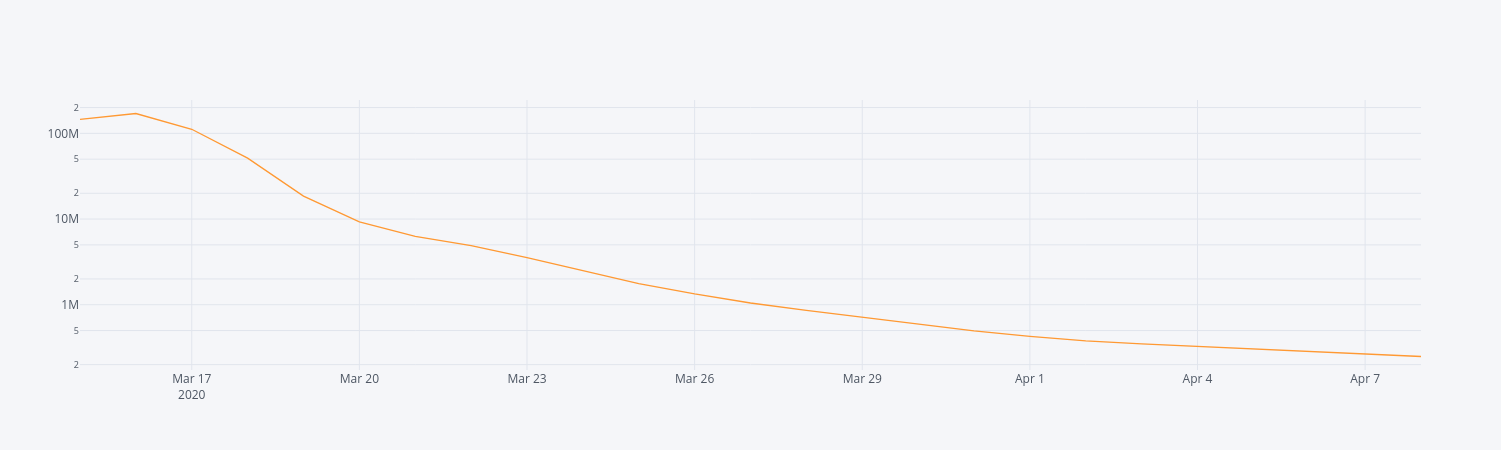

In [35]:
n_sigma = 3
beginning_of_data = pd.Timestamp('2020-02-10')
x0 = (pd.Timestamp('today').value + beginning_of_data.value)/2

category = 'deaths'
df = get_data_V2(category)


predicted_data = []

for cutoff_date in pd.date_range('2020-03-15', pd.Timestamp('today').date()):
    globe = get_globe(df.copy(), category, threshold=threshold_for_model[category])
    globe = globe.query('date < @cutoff_date').copy()
    x = globe['date'].astype(int)
    y = globe[category]
    x_fit = pd.Series(pd.date_range('2020-02-10', '2020-05-20')).astype(int)

    x = (x-x0)/x0
    x_fit = (x_fit-x0)/x0

    coeff, cov = np.polyfit(x, y, 2, cov=True)
    tmp_coeff = coeff
    maxima = -tmp_coeff[1]/(2*tmp_coeff[0])
    expected_end_date = pd.Timestamp(maxima*x0+x0).date().isoformat()
    expected_total_deaths = int((np.exp(tmp_coeff[2] - (tmp_coeff[1]*tmp_coeff[1]) / (4 * tmp_coeff[0]))).round(-3))
    predicted_data.append([cutoff_date, expected_end_date, expected_total_deaths])
    
    
predictions = pd.DataFrame(predicted_data, columns=['date', 'end_date', 'total']).set_index('date')
predictions['end_date'].iplot()
predictions['total'].iplot(logy=True)